In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import torch
import torchvision
from torchvision import transforms as T

import os
cwd=os.getcwd()
os.chdir(cwd[:len('StableRemaster')+cwd.find('StableRemaster')])

from tqdm import tqdm

In [2]:
from src import *

In [3]:
DATA_PATH = './data/02_scenes/'

In [4]:
cap_path = f'{DATA_PATH}atla_s1e1-Scene-151.mp4'
frames = split_video(cap_path)

In [5]:
segmenter = background_segmentation_loader()

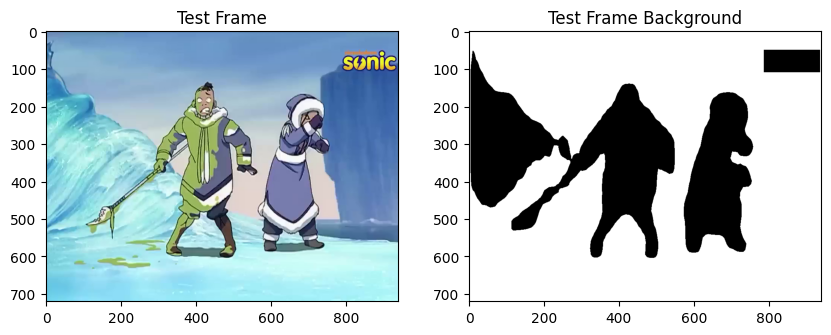

In [6]:
test_frame1 = frames[0]

bg1,bg_mask1 = segmenter(test_frame1)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
ax1.imshow(test_frame1, cmap='gray')
ax1.set_title('Test Frame')

ax2.imshow(bg_mask1, cmap='gray')
ax2.set_title('Test Frame Background')

# show the figure
plt.show()

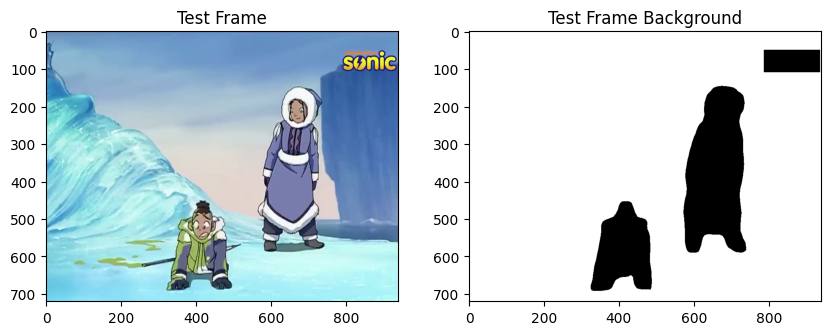

In [7]:
test_frame2 = frames[70]

bg2, bg_mask2 = segmenter(test_frame2)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
ax1.imshow(test_frame2, cmap='gray')
ax1.set_title('Test Frame')

ax2.imshow(bg_mask2, cmap='gray')
ax2.set_title('Test Frame Background')

# show the figure
plt.show()

In [8]:
def get_new_window_padding(frame_shape):
    new_width = frame_shape[0]*16//9
    padding = (new_width-frame_shape[1])//2
    return padding

def get_new_window_mask(frame_shape):
    new_width = frame_shape[0]*16//9
    new_window_mask = np.ones((frame_shape[0],new_width))
    left_bar = (new_width-frame_shape[1])//2
    right_bar = new_width-left_bar
    new_window_mask[:,left_bar:right_bar]=0
    return new_window_mask

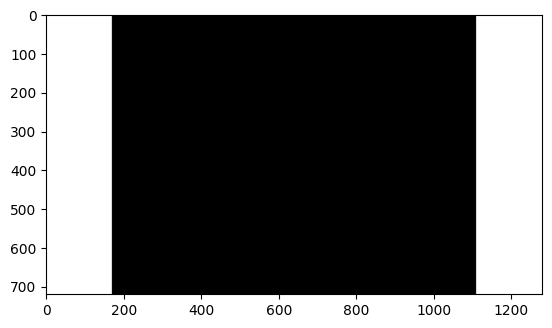

In [9]:
new_window_mask=get_new_window_mask(test_frame1.shape)
plt.imshow(new_window_mask,'gray')

In [11]:
from diffusers import StableDiffusionInpaintPipeline
from PIL import Image

In [12]:
if torch.cuda.is_available():
    print('Device: CUDA')
    print('-'*30)
    pipe = StableDiffusionInpaintPipeline.from_pretrained(
        "runwayml/stable-diffusion-inpainting",
        revision="fp16",
        torch_dtype=torch.float16,
    )
    device = torch.device('cuda')
else:
    print('Device: CPU')
    print('-'*30)
    pipe = StableDiffusionInpaintPipeline.from_pretrained("runwayml/stable-diffusion-inpainting",)
    device = torch.device('cpu')

pipe = pipe.to(device)

Device: CUDA
------------------------------


Fetching 15 files:   0%|          | 0/15 [00:00<?, ?it/s]

D:\anaconda\envs\stare\lib\site-packages\transformers\models\clip\feature_extraction_clip.py:28: FutureWarning: The class CLIPFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use CLIPImageProcessor instead.
  warnings.warn(
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.


In [80]:
def get_sample_boxes(frame_shape, sample_shape):
    assert(sample_shape[1]<frame_shape[1])
    assert(sample_shape[0]<frame_shape[0])
    x_samples = np.ceil(frame_shape[1]/sample_shape[1]).astype(int)
    y_samples = np.ceil(frame_shape[0]/sample_shape[0]).astype(int)
    
    x_pix_overlap = x_samples*sample_shape[1]-frame_shape[1]
    y_pix_overlap = y_samples*sample_shape[0]-frame_shape[0]
    
    x_pix_offset = x_pix_overlap//(x_samples-1)
    y_pix_offset = y_pix_overlap//(y_samples-1)
    
    x_starts = np.zeros(x_samples)
    y_starts = np.zeros(y_samples)
    
    for i in range(1,len(x_starts)):
        x_starts[i]=i*sample_shape[1]-x_pix_offset
        if x_pix_offset!=x_pix_overlap:
            x_starts[i]-=1
            x_pix_overlap-=1
            
    for i in range(1,len(y_starts)):
        y_starts[i]=i*sample_shape[0]-y_pix_offset
        if y_pix_offset!=y_pix_overlap:
            y_starts[i]-=1
            y_pix_overlap-=1
    
    box_starts = np.array(np.meshgrid(y_starts, x_starts)).T.reshape(-1, 2).astype(int)
    
    return box_starts

In [121]:
def outpaint_frame(frame, mask, sample_width, sample_height, pipe):
    frame=frame.copy()
    mask=mask.copy()
    sample_starts = get_sample_boxes(frame.shape[0:2],[sample_height,sample_width])
    for (y,x) in sample_starts:
        sub_frame = frame[y:(y+sample_height),x:(x+sample_width),:]
        sub_mask = mask[y:(y+sample_height),x:(x+sample_width)]
        
        sub_frame = Image.fromarray(sub_frame).convert("RGB")
        sub_mask = Image.fromarray(sub_mask).convert("RGB")
        
        new_sub_frame = pipe(prompt='animated arctic iceberg background',image=sub_frame, 
                             mask_image=sub_mask,height=sample_height,width=sample_width).images[0]
        frame[y:(y+sample_height),x:(x+sample_width),:] = np.array(new_sub_frame)
        mask[y:(y+sample_height),x:(x+sample_width)]=0
    plt.imshow(frame)
    return frame

In [122]:
m1 = get_new_window_mask(test_frame1.shape)*255
t1 = np.pad(test_frame1, ((0,0),(170,170),(0,0)),'constant',constant_values=(0,0))
#t1 = Image.fromarray(t1).convert("RGB")
#m1 = Image.fromarray(m1).convert("RGB")

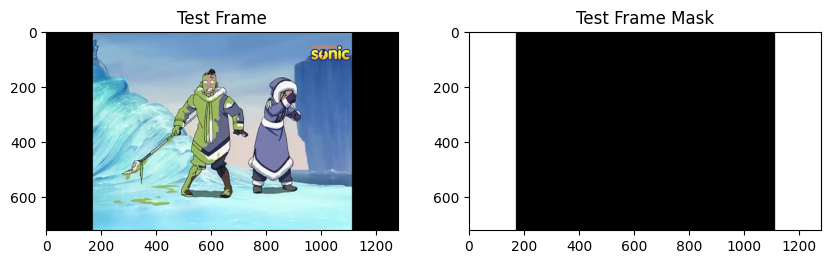

In [123]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
ax1.imshow(t1, cmap='gray')
ax1.set_title('Test Frame')

ax2.imshow(m1, cmap='gray')
ax2.set_title('Test Frame Mask')

# show the figure
plt.show()

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

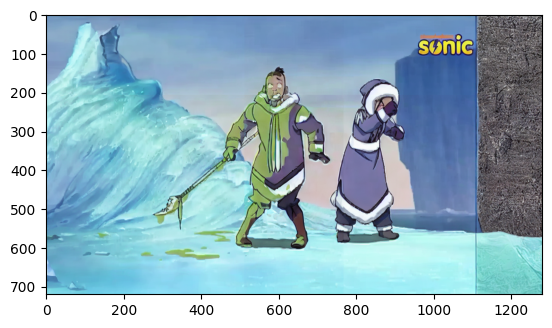

In [125]:
frame = outpaint_frame(t1, m1, 768, 512, pipe)

In [ ]:
plt.imshow(frame)
plt.title('Expanded Frame')